# Imports

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Exploring

In [ ]:
dataframe = pd.read_csv ('hotel_bookings.csv')
dataframe.head()
dataframe[dataframe['country'] == 'ESP']
dataframe[dataframe['country'] == 'PRT']

# Histograms

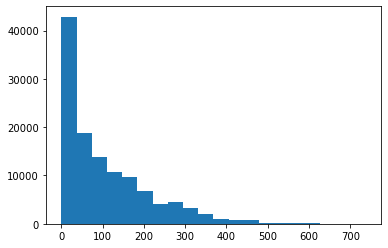

In [63]:
plt.hist(dataframe["lead_time"], bins=20)
plt.show()

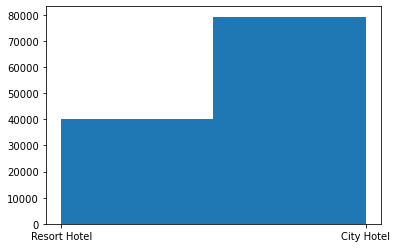

In [64]:
plt.hist(dataframe["hotel"], bins=2)
plt.show()

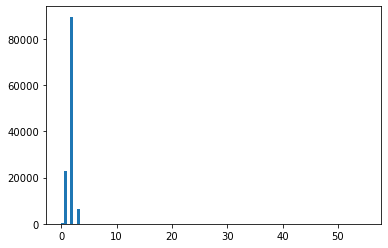

In [65]:
plt.hist(dataframe["adults"], bins=100)
plt.show()

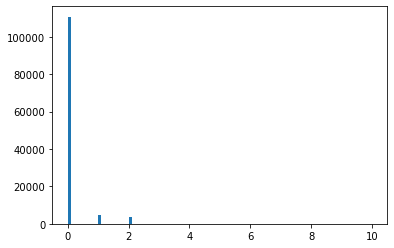

In [71]:
plt.hist(dataframe["children"], bins=100)
plt.show()

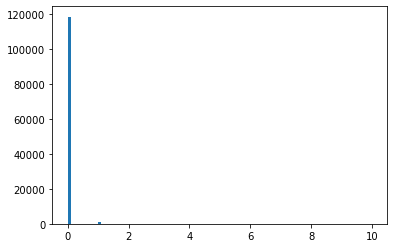

In [75]:
plt.hist(dataframe["babies"], bins=100)
plt.show()

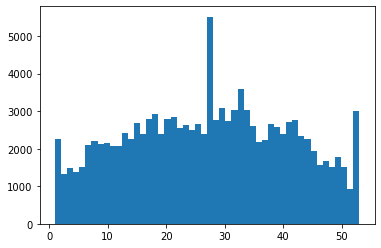

In [77]:
plt.hist(dataframe["arrival_date_week_number"], bins=50)
plt.show()

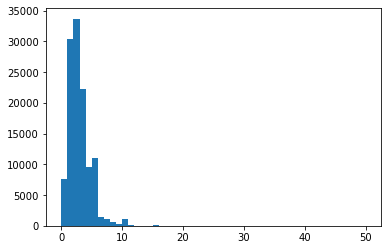

In [78]:
plt.hist(dataframe["stays_in_week_nights"], bins=50)
plt.show()

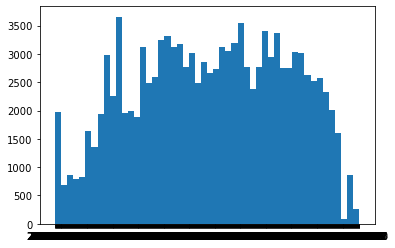

In [80]:
plt.hist(dataframe["reservation_status_date"], bins=50)
plt.show()